In [1]:
from excel_time_series_provider import ExcelTimeSeriesProvider
import pandas as pd
import numpy as np

In [2]:
##if last day falls in a weekend, takes the previous weekday (previous friday)
def add_months(date: np.datetime64, month_offset: int):
    offseted_date = date + pd.tseries.offsets.DateOffset(months=month_offset)
    if offseted_date.dayofweek >= 5:
        return offseted_date + pd.tseries.offsets.DateOffset(days = 4-offseted_date.dayofweek)
    return offseted_date

In [3]:
##parse time series and create resulting dataframe
filename = "Neste and SXXP price.xlsx"
ts_provider = ExcelTimeSeriesProvider(filename)
NESTE_ts = ts_provider.get_time_series("NESTE FH Equity", "PX_LAST")
SXXP_ts = ts_provider.get_time_series("SXXP Index", "PX_LAST")
dates = ts_provider.get_time_series("Dates")
ts_df = pd.DataFrame(list(zip(dates, NESTE_ts, SXXP_ts)),
               columns =['Dates', 'NESTE FH Equity', 'SXXP Index'], index=dates)
ts_df.head()

,Dates,NESTE FH Equity,SXXP Index
2012-11-14,2012-11-14,2.3137,268.14
2012-11-15,2012-11-15,2.3036,265.52
2012-11-16,2012-11-16,2.2433,262.86
2012-11-19,2012-11-19,2.3954,268.58
2012-11-20,2012-11-20,2.3954,269.49


In [4]:
ts_df['daily_relative_performance'] = ts_df['NESTE FH Equity'] / ts_df['SXXP Index']
ts_df.head()

,Dates,NESTE FH Equity,SXXP Index,daily_relative_performance
2012-11-14,2012-11-14,2.3137,268.14,0.008629
2012-11-15,2012-11-15,2.3036,265.52,0.008676
2012-11-16,2012-11-16,2.2433,262.86,0.008534
2012-11-19,2012-11-19,2.3954,268.58,0.008919
2012-11-20,2012-11-20,2.3954,269.49,0.008889


In [5]:
ts_df['3M rolling max'] = [
    ts_df.loc[
        edt - pd.tseries.offsets.DateOffset(months=3):edt, 'daily_relative_performance'
    ].max() if (edt - pd.tseries.offsets.DateOffset(months=3) >= ts_df['Dates'].iloc[0]) else np.NaN for edt in ts_df.index
]

print(ts_df.tail())
## test code for the 3m rolling max logic
# first_3m_window_end_date = ts_df['Dates'].iloc[0] + pd.tseries.offsets.DateOffset(months=3)
# for index, row in ts_df.loc[first_3m_window_end_date::].iterrows():
#     if row['3M rolling max'] != ts_df.loc[index-pd.tseries.offsets.DateOffset(months=3):index]['daily_relative_performance'].max():
#         print(row['3M rolling max'])
#         print(ts_df.loc[index-pd.tseries.offsets.DateOffset(months=3):index]['daily_relative_performance'].max())
#         print(index)

                Dates  NESTE FH Equity  SXXP Index   
2022-12-08 2022-12-08            45.98      435.47  \
2022-12-09 2022-12-09            45.74      439.13   
2022-12-12 2022-12-12            45.81      436.98   
2022-12-13 2022-12-13            46.20      442.60   
2022-12-14 2022-12-14            46.21      440.94   

            daily_relative_performance  3M rolling max  
2022-12-08                    0.105587        0.118666  
2022-12-09                    0.104160        0.118666  
2022-12-12                    0.104833        0.118666  
2022-12-13                    0.104383        0.118666  
2022-12-14                    0.104799        0.118666  


In [6]:
forward_looking_relative_performance ={'1M':[], '3M':[], '6M':[]}
last_date = ts_df['Dates'].iloc[-1]
for index,row in ts_df.iterrows():
    if row['3M rolling max'] == row['daily_relative_performance']:
        offset_1m = add_months(index, 1)
        if offset_1m <= last_date:
            forward_looking_relative_performance['1M'].append((row['3M rolling max'], ts_df.loc[offset_1m]['daily_relative_performance'], index))
        else:
            break
        offset_3m = add_months(index, 3)
        if offset_3m <= last_date:
            forward_looking_relative_performance['3M'].append((row['3M rolling max'], ts_df.loc[offset_3m]['daily_relative_performance'], index))
        else:
            continue
        offset_6m = add_months(index, 6)
        if offset_6m <= last_date:
            forward_looking_relative_performance['6M'].append((row['3M rolling max'], ts_df.loc[offset_6m]['daily_relative_performance'], index))
print(forward_looking_relative_performance)

{'1M': [(0.010603947722985717, 0.010249217075984836, Timestamp('2013-04-25 00:00:00')), (0.010611990988264569, 0.009985785123966943, Timestamp('2013-04-29 00:00:00')), (0.011545715321969071, 0.012153235571101843, Timestamp('2013-08-01 00:00:00')), (0.011739030553641167, 0.013986629134412384, Timestamp('2013-08-23 00:00:00')), (0.011739358906988963, 0.01366142738483164, Timestamp('2013-08-26 00:00:00')), (0.01220628072639711, 0.013873086040105067, Timestamp('2013-08-27 00:00:00')), (0.012230033652084096, 0.013873086040105067, Timestamp('2013-08-29 00:00:00')), (0.012253911665676373, 0.013926767270504197, Timestamp('2013-09-02 00:00:00')), (0.01266286698919743, 0.013806170247132933, Timestamp('2013-09-03 00:00:00')), (0.013069392075147186, 0.01390009358159347, Timestamp('2013-09-04 00:00:00')), (0.014541962556488056, 0.014116793966934158, Timestamp('2013-09-10 00:00:00')), (0.012466242113332153, 0.012037245381335859, Timestamp('2014-04-04 00:00:00')), (0.012485968473847623, 0.01209921733

In [7]:
perf_metrics = {key: {} for key in forward_looking_relative_performance.keys()}
for key in perf_metrics.keys():
    geometric_rr = [(a[1]-a[0])/a[0] for a in forward_looking_relative_performance[key]]
    perf_metrics[key]['nb_obs'] = len(geometric_rr)
    perf_metrics[key]['average_geometric_relative_return'] = np.average(geometric_rr)
    perf_metrics[key]['stdev_geometric_relative_return'] = np.std(geometric_rr)
    perf_metrics[key]['median_geometric_relative_return'] = np.median(geometric_rr)
    perf_metrics[key]['max_geometric_relative_return'] = np.max(geometric_rr)
    perf_metrics[key]['min_geometric_relative_return'] = np.min(geometric_rr)
    perf_metrics[key]['annualized_average_geometric_relative_return'] = pow((1+perf_metrics[key]['average_geometric_relative_return']),12/int(key[0]))-1

metrics_df = pd.DataFrame.from_dict(perf_metrics, orient = 'index')
metrics_df.head()

,nb_obs,average_geometric_relative_return,stdev_geometric_relative_return,median_geometric_relative_return,max_geometric_relative_return,min_geometric_relative_return,annualized_average_geometric_relative_return
1M,264,0.019742,0.073503,0.019852,0.269550,-0.142125,0.264397
3M,264,0.062617,0.132258,0.069211,0.419833,-0.326652,0.274990
6M,252,0.125665,0.185591,0.117268,0.601101,-0.278226,0.267121


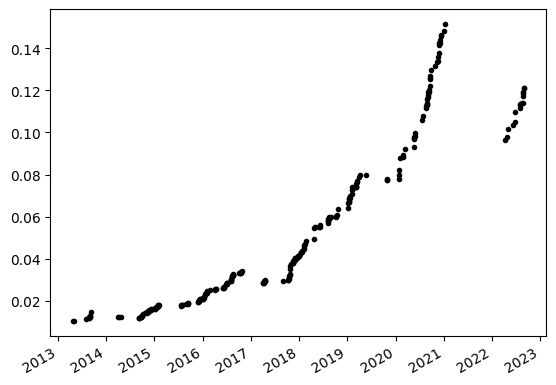

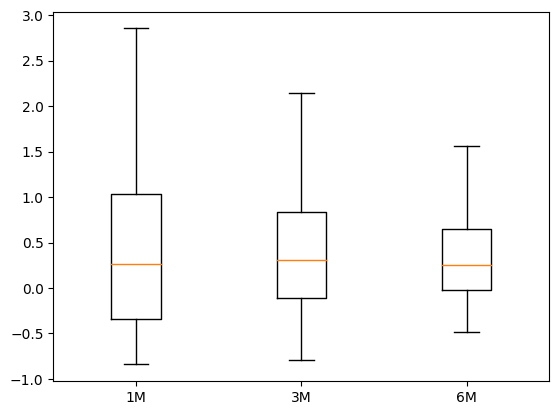

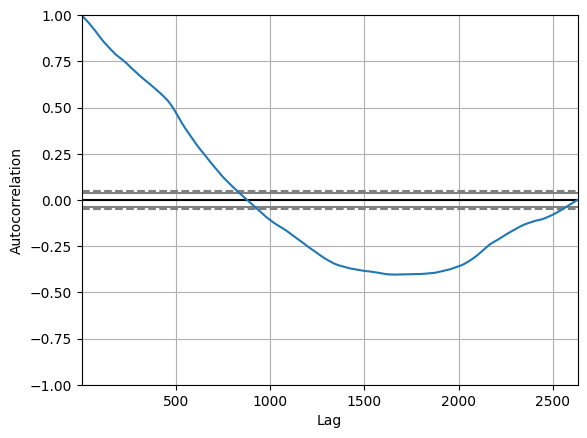

In [19]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
s= pd.Series([a[0] for a in forward_looking_relative_performance['1M']], index=[a[2] for a in forward_looking_relative_performance['1M']])
s.plot(style = 'k.')
pyplot.show()
annualized_geometric_rr = []
label_keys = forward_looking_relative_performance.keys()
for key in label_keys:
    annualized_geometric_rr.append([pow(a[1]/a[0], 12/int(key[0]))-1 for a in forward_looking_relative_performance[key]])
pyplot.boxplot(annualized_geometric_rr, labels=label_keys, showfliers=False)
pyplot.show()
autocorrelation_plot(ts_df['daily_relative_performance'])
pyplot.show()